# Data

In [48]:
positive_sentences = open('data/positive.txt', 'r')
negative_sentences = open('data/negative.txt', 'r')
positive_list = [line.replace('\n', '') for line in positive_sentences.readlines()]
negative_list = [line.replace('\n', '') for line in negative_sentences.readlines()]

positive_list[:5]

['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean claud van damme or steven segal . ',
 'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle earth . ',
 'effective but too tepid biopic',
 'if you sometimes like to go to the movies to have fun , wasabi is a good place to start . ',
 "emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one . "]

In [60]:
import pandas as pd
positive_df = pd.DataFrame({'sentences':positive_list})
positive_df['feeling'] = 1
negative_df = pd.DataFrame({'sentences':negative_list})
negative_df['feeling'] = 0

In [92]:
data = pd.concat([positive_df, negative_df])
# lower case
data['sentences'] = data['sentences'].str.lower()
# shuffle
data = data.sample(frac=1).reset_index(drop=True)
data.head(10)

,sentences,feeling
0,"infidelity drama is nicely shot , well edited ...",1
1,exactly what you'd expect from a guy named kao...,0
2,"it's got the brawn , but not the brains .",0
3,the transporter bombards the viewer with so ma...,0
4,trademark american triteness and simplicity ar...,1
5,the way home is an ode to unconditional love a...,1
6,. . . a rather bland affair .,0
7,tells ( the story ) with such atmospheric ball...,1
8,almost everything about the film is unsettling...,0
9,national lampoon's van wilder could be the wor...,0


In [93]:
import string
def remove_punctuation(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation.replace("'",''))])
    return s
# remove ponctuation except "'"
data['sentences'] = data['sentences'].apply(remove_punctuation())
data.head(10)

,sentences,feeling
0,infidelity drama is nicely shot well edited a...,1
1,exactly what you'd expect from a guy named kaos,0
2,it's got the brawn but not the brains,0
3,the transporter bombards the viewer with so ma...,0
4,trademark american triteness and simplicity ar...,1
5,the way home is an ode to unconditional love a...,1
6,a rather bland affair,0
7,tells the story with such atmospheric ballas...,1
8,almost everything about the film is unsettling...,0
9,national lampoon's van wilder could be the wor...,0


In [103]:
# tokenize
tokens = [ s.split() for s in data['sentences']]
len(tokens)

10662

In [104]:
tokens[0]

['infidelity',
 'drama',
 'is',
 'nicely',
 'shot',
 'well',
 'edited',
 'and',
 'features',
 'a',
 'standout',
 'performance',
 'by',
 'diane',
 'lane']

# Word vector

In [94]:
import gensim.downloader as api
NEED_DOWNLOAD = False
if NEED_DOWNLOAD:
    word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data
    word_vectors.save('data/glove-wiki-gigaword-100.bin')
else:
    word_vectors.load('data/glove-wiki-gigaword-100.bin')

In [95]:
word_vectors.most_similar(positive=['paris', 'germany'], negative=['france'])

[('berlin', 0.8846380710601807),
 ('frankfurt', 0.7985544204711914),
 ('vienna', 0.76759934425354),
 ('munich', 0.7542588710784912),
 ('hamburg', 0.718237042427063),
 ('bonn', 0.6890878677368164),
 ('prague', 0.6842441558837891),
 ('cologne', 0.6762093305587769),
 ('zurich', 0.6653269529342651),
 ('leipzig', 0.6619254350662231)]

In [96]:
print(word_vectors.doesnt_match("breakfast cereal dinner lunch".split()))

cereal


C:\Users\antho\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [97]:
word_vectors.similarity('woman', 'man')

0.8323494

# Prepare data

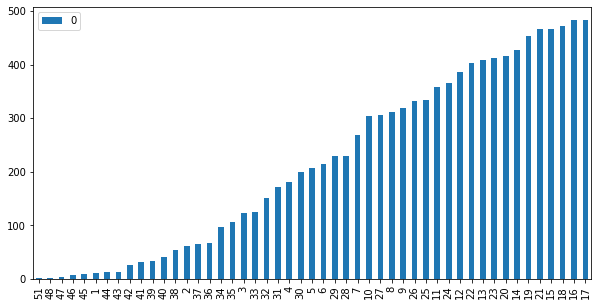

In [144]:
# display distribution of the sentences' sizes
import pandas
from collections import Counter
sizes = [len(el) for el in tokens]
letter_counts = Counter(sizes)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')

df.sort_values(by = 0).plot(kind='bar', figsize=(10,5));

In [127]:
from tqdm import tqdm

keys = word_vectors.vocab.keys()
vocabIndex = {}
for w in keys:
	vocabIndex[w] = word_vectors.vocab[w].index

X = []
y = []


for el in tqdm(tokens):
    row = np.zeros((64, 100))
    words = el
    for j in range(min(64, len(words))):
        if words[j] in word_vectors.vocab:
            indexVal = vocabIndex[words[j]]
            row[j] = word_vectors[words[j]]
    X.append(row)
	
X = np.asarray(X)
y = np.asarray(data['feeling'].values)

X.shape

100%|██████████| 10662/10662 [00:00<00:00, 17353.69it/s]


(10662, 64, 100)